# Recurrent Neural Networks

In [76]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional

## Time series forecasting

In [77]:
df = pd.read_csv('monthysales.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [78]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)  #the last date of each month
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


<AxesSubplot:xlabel='Adjustments'>

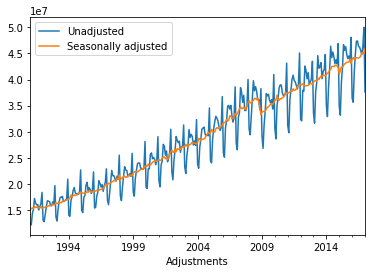

In [79]:
df.plot()

In [80]:
split_date = pd.Timestamp('01-01-2011')

In [81]:
#Split train and test set ordered by time
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

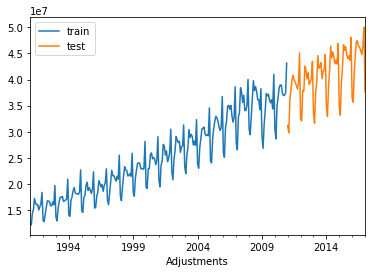

In [82]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [83]:


sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [84]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [85]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [86]:
X_train[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [87]:
y_train[:4]

array([[0.        ],
       [0.0704258 ],
       [0.09531795],
       [0.16362761]])

### Recurrent predictor

In [88]:
X_train.shape

(239, 1)

In [89]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape #None to add additional dimension

(239, 1, 1)

In [90]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]
print(X_train_t.shape)
print(X_test_t.shape)

(239, 1, 1)
(72, 1, 1)


In [91]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))  #input_shape = timesteps, input_dim

model.add(Dense(1)) #output is number (regression problem) so we don't apply any activation function

model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 3s 3ms/step - loss: 0.1473
Epoch 2/100
239/239 [==============================] - 1s 2ms/step - loss: 0.0295
Epoch 3/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0254
Epoch 4/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 5/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 6/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0105
Epoch 7/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 8/100
239/239 [==============================] - 1s 3ms/step - loss: 0.0092
Epoch 9/100
239/239 [==============================] - 0s 2ms/step - loss: 0.0115
Epoch 00009: early stopping


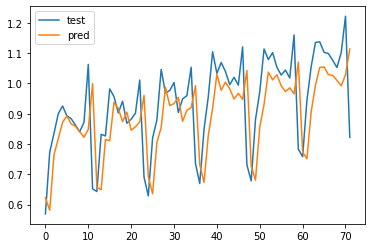

In [93]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['test', 'pred'])

# Windows

In [94]:
train_sc.shape

(240, 1)

In [95]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [96]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s) #shift fn from pandas to get features from the past to predict the future
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [97]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [98]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [99]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [100]:
X_train.shape

(228, 12)

In [101]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### LSTM on Windows with 1 timestep 12 features

In [102]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [103]:
X_train_t.shape

(228, 1, 12)

In [104]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 2s 2ms/step - loss: 0.1066
Epoch 2/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 3/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 4/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 5/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 6/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 7/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 8/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 9/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 10/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 11/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 12/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 13/100


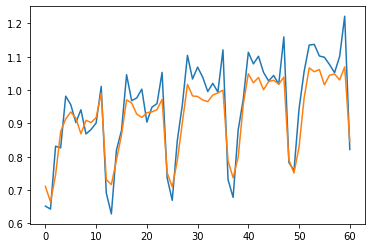

In [107]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

###  LSTM on Windows with 12 timesteps 1 feature

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

In [108]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [109]:
X_train_t.shape

(228, 12, 1)

In [110]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

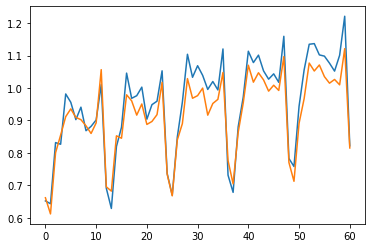

In [113]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

###  Stacked LSTM with 2 layers

In [114]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, return_sequences= True, input_shape=(12, 1)))
model.add(LSTM(6))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [115]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

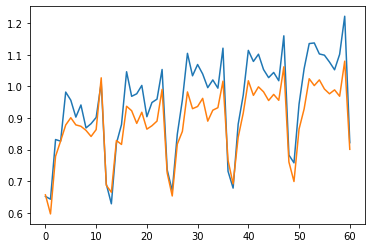

In [116]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

###  Stacked LSTM with 3 layers

In [117]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, return_sequences= True, input_shape=(12, 1)))
model.add(LSTM(6, return_sequences= True))
model.add(LSTM(6))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [118]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

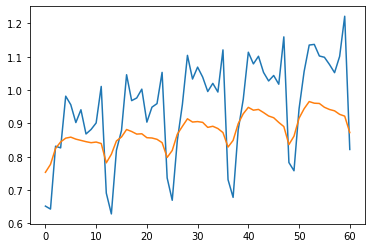

In [119]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

### RNN

In [120]:
K.clear_session()
model = Sequential()
model.add(SimpleRNN(6, input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

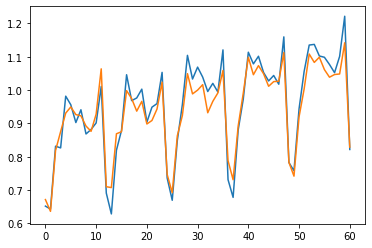

In [121]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

### GRU

In [122]:
K.clear_session()
model = Sequential()
model.add(GRU(6, input_shape=(12, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

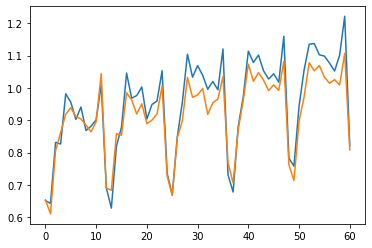

In [123]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

### Bidirectional-LSTM


In [124]:
K.clear_session()
model = Sequential()
model.add(Bidirectional(LSTM(6, input_shape=(12, 1))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

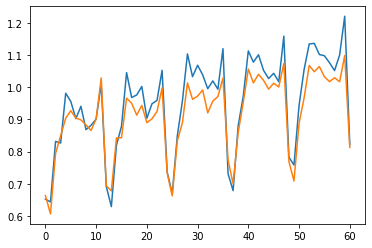

In [125]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

### Bidirectional-GRU

In [126]:
K.clear_session()
model = Sequential()
model.add(Bidirectional(GRU(6, input_shape=(12, 1))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=0)

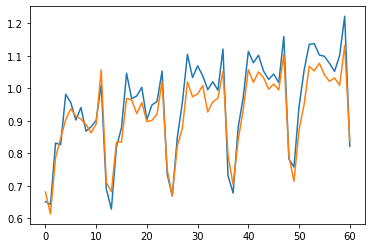

In [127]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)